In [1]:
import glob
import pandas as pd
import statsmodels.sandbox.stats.multicomp
from pylab import *
import seaborn as sns

Function to correct for multiple testing

In [2]:
def correct(p_values):
    return statsmodels.sandbox.stats.multicomp.multipletests(p_values, alpha = 0.05, method = 'fdr_bh' )

Loading STR data

In [3]:
vSTRs = pd.read_table('../data/STRs_depth5_chr_start_maf09.annotated.tsv')
p = vSTRs[vSTRs['WHERE']=='PROMOTER']
np = vSTRs[vSTRs['WHERE']!='PROMOTER']
p['GENE2'] = p.Closest
vSTRs = pd.concat([p, np])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading results of phenotype tests. Phenotype data was downloaded from **AraPheno**, using the REST API  (https://arapheno.1001genomes.org/faq/rest/). The R script pheno_lme.R was used to run then analysis and generated the output loaded next.

In [4]:
frames = []
for i in glob.glob('../data/phenotypes/observed/*.csv'):
    name = i.split('lmeResDF')[1].replace('_', '').replace(' ', '_').split('.')[0]
    print name
    frame = pd.read_csv(i)
    frame['Phenotype'] = [name for i in frame.Where]
    frames.append(frame)
phen = pd.concat(frames)
phen = phen[phen['Start'].isin(set(vSTRs.CHR_START))]

0W_GH_FT
0W_GH_LN
0W
2W
4W
8W_GH_FT
8W_GH_LN
8W
After_Vern_Growth
Aphid_number
Area_sweden_2009_(1st_experiment)
Area_sweden_2009_(2nd_experiment)
As_CFU2
As2_CFU2
As75_022510
As75_Hydro_Rootoot
As75_Soil_3
As75_Soil_Leaf
As75_Soil_Seed
As75
At1_CFU2
At2_CFU2
B11_022510
B11_Hydro_Leaf
B11_Hydro_Rootoot
B11_Soil_3
B11_Soil_Leaf
B11_Soil_Seed
B11
Bacterial_titer
Bs_CFU2
Bs
Ca43_022510
Ca43_Hydro_Leaf
Ca43_Hydro_Rootoot
Ca43_Soil_Leaf
Ca43_Soil_Seed
Ca43_Soil
Ca43
Cd111_022510
Cd111_Soil_3
Cd114_Hydro_Leaf
Cd114_Hydro_Rootoot
Cd114_Soil_Leaf
Cd114_Soil_Seed
Cd114
Co59_022510
Co59_Hydro_Leaf
Co59_Hydro_Root
Co59_Soil_3
Co59_Soil_Leaf_1
Co59_Soil_Seed
Co59
Cu65_022510
Cu65_Hydro_Leaf
Cu65_Hydro_Root
Cu65_Soil_3
Cu65_Soil_Leaf_1
Cu65_Soil_Seed
Cu65
DSDS50
DTF_spain_2008_(1st_experiment)
DTF_spain_2008_(2nd_experiment)
DTF_spain_2009_(1st_experiment)
DTF_spain_2009_(2nd_experiment)
DTF_sweden_2008_(1st_experiment)
DTF_sweden_2008_(2nd_experiment)
DTF_sweden_2009_(1st_experiment)
DTF_sweden_20

In [5]:
phen_gene = phen[phen['Where'].isin(['PROMOTER', 'CDS', 'THREE_PRIME_UTR', 'FIVE_PRIME_UTR', 'INTRON', 'SPANNING'])]
loci_gene_mapper = vSTRs.set_index('CHR_START')['Closest'].to_dict()
phen_gene['Gene'] = [loci_gene_mapper[i.Start] 
                     if loci_gene_mapper[i.Start] != 'None' 
                     else i.Gene 
                     for i in phen_gene.itertuples()]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Control

In [6]:
frames = []
for i in glob.glob('../data/phenotypes/negative_controls/*csv'):
    name = i.split('lmeResDF')[1].replace('_', '').replace(' ', '_').split('.')[0]
    frame = pd.read_csv(i)
    frame['Phenotype'] = [name for i in frame.Where]
    frames.append(frame)
phen_c = pd.concat(frames)
phen_c = phen_c[phen_c['Start'].isin(set(vSTRs.CHR_START))]

In [7]:
phen_gene_c = phen_c[phen_c['Where'].isin(['PROMOTER', 'CDS', 'THREE_PRIME_UTR', 'FIVE_PRIME_UTR', 'INTRON', 'SPANNING'])]
phen_gene_c['Gene'] = [loci_gene_mapper[i.Start] 
                     if loci_gene_mapper[i.Start] != 'None' 
                     else i.Gene 
                     for i in phen_gene_c.itertuples()]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## QQ plot

In [78]:
def plot_QQ(observed, control, p):
    o = observed
    c = control
    real_sort = sort(o.p_value)
    control_sort = sort(c.p_value)
    obs_x = [-log10(i) for i in sorted(linspace(0, 1, len(real_sort)))]
    obs_y = [-log10(i) for i in real_sort]
    control_x = [-log10(i) for i in sorted(linspace(0, 1, len(control_sort)))]
    control_y = [-log10(i) for i in control_sort]

    # Plotting 
    fig, ax = subplots(figsize = (4,4))

    scatter(obs_x, obs_y, color = 'Red', s = 3)
    scatter(control_x, control_y, color = 'Black', s = 3, alpha = 0.5)
    plot([0,5],[0,5], color="gray")

    #legend(loc = 'upper left')

    #xlim(0, 5)
    #ylim(0, 50)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticklabels(ax.get_xticks(), size=15)
    ax.set_yticklabels(ax.get_yticks(), size=15)
    ax.legend(fontsize = 16)
    tight_layout()
    savefig('../Figures/phen_%s_QQ_plot.pdf' % p, type = 'pdf', transparent = True)
    savefig('../Figures/phen_%s_QQ_plot.png'% p, type = 'png', transparent = True)

    show()

Loading phenotype data

In [73]:
metadata = pd.read_csv('../data/AccListSraRunTable.csv')
mapper = metadata.set_index('Ecotype')['ACCESSION'].to_dict()
phenodata = pd.read_csv('../data/MergedPhenotypes.csv', header = None,
            names = ['Phenotype', 'Ecotype', 'Name', 'CS_number', 'lon', 'lat', 'Country', 'value', 'phen_id'])
phenodata = phenodata[phenodata['Ecotype'].isin(mapper.keys())]
phenodata['ACCESSION'] = [mapper[ecotype] for ecotype in phenodata.Ecotype]

phenodata['Phenotype'] = [x.replace(' ', '_') for x in phenodata.Phenotype]
phen_gene['Phenotype'] = [x.replace(' ', '_') for x in phen_gene.Phenotype]

replace_ = []
for x in phenodata['Phenotype']:
    if x[-1] == '_':
        x = x[:-1]
    else:
        x = x
    replace_.append(x)

phenodata['Phenotype'] = replace_



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Figure 5a. Genic QQ plot of selected phenotypes

Na23_Soil_Seed


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


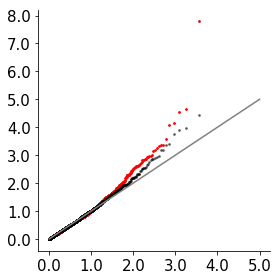

1708    AT2G32010.1
4805      AT5G49580
661     AT1G66180.1
438     AT1G54230.1
636     AT1G64670.1
2240    AT2G14210.1
Name: Gene, dtype: object
DTFlocSweden2009


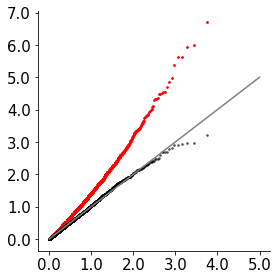

2233    AT1G18750.1
4297      AT3G27920
4201    AT2G22490.1
2640    AT2G24600.1
1831      AT1G79840
6854    AT4G35950.1
Name: Gene, dtype: object
Aphid_number


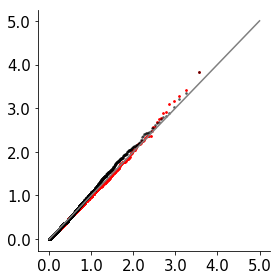

5024    AT5G57800.1
1293    AT1G18620.1
2110    AT2G46990.1
2618    AT3G45290.1
5153    AT5G63050.1
2010    AT2G43040.1
Name: Gene, dtype: object


In [79]:
for p in ['Na23_Soil_Seed', 'DTFlocSweden2009', 'Aphid_number']:
    print p
    obs = phen_gene[phen_gene['Phenotype']==p]
    con = phen_gene_c[phen_gene_c['Phenotype']==p]
    plot_QQ(obs, con, p)
    print obs.sort_values(by = 'p_value').head(6).Gene

## Figure 5b. Top outlier boxplots

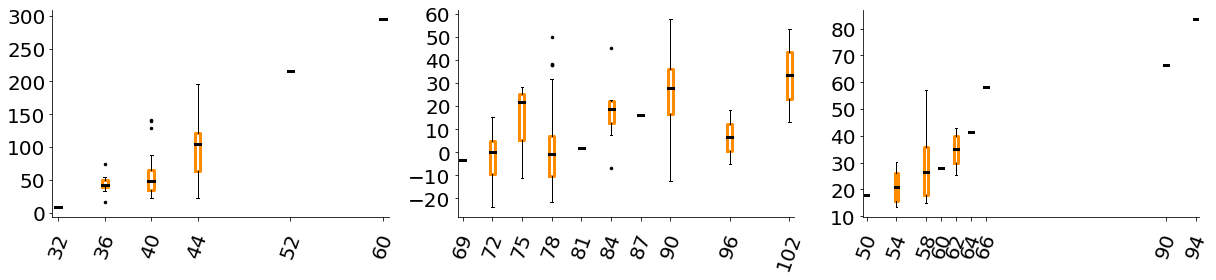

In [86]:
f, axes = subplots(nrows = 1, ncols = 3, figsize = (17,4), sharey = False)
counter = -1
n = 0

boxprops = dict(linestyle='-', linewidth=3, color='darkorange')
flierprops = dict(marker='.', markerfacecolor='black', markersize=5, linestyle='none')
medianprops = dict(linestyle='-', linewidth=3, color='black')



for pair in [('AT2G32010.1', 'Na23_Soil_Seed'), ('AT1G18750.1', 'DTFlocSweden2009'), ('AT5G57800.1', 'Aphid_number')]:
    counter += 1
    ax = axes[counter]
        
    df = phen_gene[phen_gene['Phenotype']==pair[1]]
    gene = pair[0]

    loci = df[df.Gene == gene].Start.values[0]
    
    #print df[df.Gene == gene]
    f = phenodata[phenodata['Phenotype']==pair[1]][['ACCESSION', 'value']]
    r = vSTRs[vSTRs['CHR_START']==loci][['ACCESSION', 'STR_DOSAGE']]
    df2 = pd.merge(f, r)[['value', 'STR_DOSAGE']]
    phen_values = []
    rls = []
    for i in set(df2.STR_DOSAGE):
        rls.append(i)
        phen_values.append(list(df2[df2['STR_DOSAGE']==i].value.values))
    
    ax.boxplot(phen_values, positions = rls, boxprops = boxprops, flierprops = flierprops, medianprops = medianprops)
    setp(ax.xaxis.get_majorticklabels(), rotation=70, size = 20)
    setp(ax.yaxis.get_majorticklabels(), rotation=0, size = 20)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='x', pad=10)
    
tight_layout()
savefig('../Figures/Top3_pSTRs_by_p.pdf', type = 'pdf', transparent = True)
savefig('../Figures/Top3_pSTRs_by_p.png', type = 'png', transparent = True)
show()

## Supplementary Data 3 - Phenotype test data

In [104]:
phen.to_csv('../data/phenotype_nlme_results.csv')